# Emma Ch.1 Narrative Feature Variance (DP many↔many alignment)

This notebook uses a **dynamic-programming (DP) many↔many aligner** to match original vs. back-translated sentences,
with **SBERT** embeddings if available or **TF-IDF** fallback. It then computes per-pair deltas, POS-change logs, visuals, and a coverage report.

© 2025 Johennie Helton. Licensed under the Apache License 2.0.

**Inputs (place these next to this notebook):**
- `emma_ch1_en.txt` original English
- `emma_ch1_back_en.txt` back-translated English (EN→ES→EN)
- `emma_ch1_es.txt` Spanish reference (optional, not required)


## 1) Setup

In [ ]:
import os, re, math
from typing import List, Tuple, Dict

import nltk
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Uncomment if first run in a fresh env:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('vader_lexicon')

lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

# Try SBERT; fall back to TF-IDF inside aligner functions if import fails
USE_SBERT = True
MODEL_NAME = 'all-MiniLM-L6-v2'
try:
    from sentence_transformers import SentenceTransformer, util
except Exception as e:
    USE_SBERT = False
    print('SBERT unavailable; will fall back to TF-IDF backend for alignment.\n', e)


## 2) Helpers

In [2]:
def normalize_for_seg(s: str) -> str:
    return (s.replace('—', '-')
             .replace('–', '-')
             .replace('’', "'")
             .replace('_', '')
             .replace('  ', ' ')
             .strip())

def is_alpha_token(t: str) -> bool:
    return bool(re.fullmatch(r"[A-Za-z’\-]+", t))

def safe_div(n, d): 
    return n / d if d else 0.0

def syllables_en(word: str) -> int:
    w = re.sub(r"[^a-z]", "", word.lower())
    if not w: return 0
    vowels = 'aeiouy'
    c = 0; prev = False
    for ch in w:
        v = ch in vowels
        if v and not prev: c += 1
        prev = v
    if w.endswith('e') and c > 1: c -= 1
    return max(c, 1)

def flesch_reading_ease(text: str) -> float:
    toks = [w for w in word_tokenize(text) if is_alpha_token(w)]
    sents = max(1, text.count('.') + text.count('!') + text.count('?'))
    num_words = len(toks)
    syl = sum(syllables_en(w) for w in toks)
    ASL = safe_div(num_words, sents)
    ASW = safe_div(syl, num_words)
    return round(206.835 - 1.015 * ASL - 84.6 * ASW, 1)

def sent_metrics(text: str) -> Dict:
    toks = [w for w in word_tokenize(text) if is_alpha_token(w)]
    lower = [w.lower() for w in toks]
    n_tokens = len(lower)
    n_types = len(set(lower))
    ttr = safe_div(n_types, n_tokens)
    tags = pos_tag(lower)
    n_nouns = sum(1 for _,t in tags if t.startswith('NN'))
    n_verbs = sum(1 for _,t in tags if t.startswith('VB'))
    n_adjs = sum(1 for _,t in tags if t.startswith('JJ'))
    n_advs = sum(1 for _,t in tags if t.startswith('RB'))
    lexical_density = safe_div(n_nouns + n_verbs + n_adjs + n_advs, n_tokens)
    avg_word_len = safe_div(sum(len(w) for w in lower), n_tokens)
    flesch = flesch_reading_ease(text)
    sentiment = sia.polarity_scores(text)['compound']
    return {
        'tokens': n_tokens,
        'types': n_types,
        'ttr': ttr,
        'n_nouns': n_nouns,
        'n_verbs': n_verbs,
        'n_adjs': n_adjs,
        'n_advs': n_advs,
        'lexical_density': lexical_density,
        'avg_word_len': avg_word_len,
        'flesch': flesch,
        'chars': len(text),
        'sentiment': sentiment,
        'tags': tags,
    }

def penn_to_wn(tag: str):
    if tag.startswith('J'): return wn.ADJ
    if tag.startswith('V'): return wn.VERB
    if tag.startswith('N'): return wn.NOUN
    if tag.startswith('R'): return wn.ADV
    return None

def lemmatize_tagged(tokens_tags: List[Tuple[str,str]]):
    out = []
    for w,t in tokens_tags:
        wn_tag = penn_to_wn(t)
        if wn_tag:
            out.append((lemmatizer.lemmatize(w, wn_tag), t))
        else:
            out.append((lemmatizer.lemmatize(w), t))
    return out

def compare_pos_lists(list1: List[str], list2: List[str]):
    s1, s2 = [x.lower() for x in list1], [x.lower() for x in list2]
    set1, set2 = set(s1), set(s2)
    removed = sorted(set1 - set2)
    added   = sorted(set2 - set1)
    return removed, added

def wordnet_max_sim(w1: str, w2: str, wn_pos):
    s1 = wn.synsets(w1, pos=wn_pos)
    s2 = wn.synsets(w2, pos=wn_pos)
    if not s1 or not s2: return None
    best = 0.0; found = False
    for a in s1:
        for b in s2:
            sim = a.path_similarity(b)
            if sim is not None:
                found = True
                if sim > best: best = sim
    return best if found else None


## 3) Load your uploaded files

In [3]:
en_path = 'emma_ch1_en.txt'
back_en_path = 'emma_ch1_back_en.txt'
es_path = 'emma_ch1_es.txt'  # optional

def read_text(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

orig_text = read_text(en_path)
back_text = read_text(back_en_path)

orig_sentences = [normalize_for_seg(s) for s in sent_tokenize(orig_text)]
back_sentences = [normalize_for_seg(s) for s in sent_tokenize(back_text)]

print(f'Original sentences: {len(orig_sentences)} | Back sentences: {len(back_sentences)}')


Original sentences: 162 | Back sentences: 139


## 4) DP many↔many alignment (SBERT or TF-IDF backend) v2 spans

In [ ]:
# Embedding backend
def embed_sentences(sents):
    if USE_SBERT:
        model = SentenceTransformer(MODEL_NAME)
        return model.encode(sents, convert_to_tensor=False, show_progress_bar=False)
    else:
        # TF-IDF fallback
        from sklearn.feature_extraction.text import TfidfVectorizer
        vec = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=1)
        X = vec.fit_transform(sents)
        return X.toarray()

def cosine(a, b):
    na = np.linalg.norm(a); nb = np.linalg.norm(b)
    if na == 0 or nb == 0: return 0.0
    return float(np.dot(a, b) / (na * nb))

def dp_align_many_to_many_v2(sents1, sents2, max_merge=3, gap_penalty=0.2):
    """
    Dynamic programming alignment allowing 1..max_merge sentences on each side.
    Maximizes total similarity minus a small gap/merge penalty.
    Returns tuples: (orig_start, orig_end, orig_chunk, back_start, back_end, back_chunk, cosine_sim)
    with 1-based indices and inclusive ends.
    """
    E1 = embed_sentences(sents1)
    E2 = embed_sentences(sents2)

    n, m = len(sents1), len(sents2)
    def merged_vec(E, start, end):
        return np.mean(E[start:end], axis=0)

    NEG_INF = -1e9
    dp = np.full((n+1, m+1), NEG_INF, dtype=float)
    prev = [[None]*(m+1) for _ in range(n+1)]
    dp[0,0] = 0.0

    for i in range(n+1):
        for j in range(m+1):
            if dp[i,j] <= NEG_INF/2:
                continue
            for ai in range(1, max_merge+1):
                ii = i + ai
                if ii > n: break
                for bj in range(1, max_merge+1):
                    jj = j + bj
                    if jj > m: break
                    v1 = merged_vec(E1, i, ii)
                    v2 = merged_vec(E2, j, jj)
                    sim = cosine(v1, v2)
                    penalty = gap_penalty * (ai-1 + bj-1)
                    cand = dp[i,j] + (sim - penalty)
                    if cand > dp[ii,jj]:
                        dp[ii,jj] = cand
                        prev[ii][jj] = (i, j, ai, bj, sim)

    # Backtrack
    i, j = n, m
    out = []
    while i > 0 or j > 0:
        step = prev[i][j] if i>=0 and j>=0 else None
        if step is None:
            if i > 0 and (j == 0 or dp[i-1,j] >= dp[i,j-1]):
                i -= 1
                out.append((i, i+1, j, j, sents1[i], '', 0.0))
            elif j > 0:
                j -= 1
                out.append((i, i, j, j+1, '', sents2[j], 0.0))
            continue
        pi, pj, ai, bj, sim = step
        s1_chunk = ' '.join(sents1[pi:i])
        s2_chunk = ' '.join(sents2[pj:j])
        out.append((pi, i, pj, j, s1_chunk, s2_chunk, sim))
        i, j = pi, pj

    out.reverse()
    aligned = []
    for (i0, i1, j0, j1, s1, s2, sim) in out:
        if i1 == i0 and j1 == j0:
            continue
        # Convert to 1-based indices and inclusive ends for readability
        orig_start = i0 + 1
        orig_end   = i1
        back_start = j0 + 1
        back_end   = j1
        aligned.append((orig_start, orig_end, s1, back_start, back_end, s2, float(sim)))
    aligned = [t for t in aligned if t[2].strip() or t[5].strip()]
    return aligned

# knobs
MAX_MERGE = 3
GAP_PENALTY = 0.2

aligned_pairs = dp_align_many_to_many_v2(orig_sentences, back_sentences, max_merge=MAX_MERGE, gap_penalty=GAP_PENALTY)
print(f'Aligned pairs (DP v2): {len(aligned_pairs)} of {len(orig_sentences)}')
for row in aligned_pairs[:5]:
    o_start, o_end, s1, b_start, b_end, s2chunk, score = row
    o_label = f"[{o_start}-{o_end}]" if o_end>o_start else f"[{o_start}]"
    b_label = f"[{b_start}-{b_end}]" if b_end>b_start else f"[{b_start}]"
    print(f"{o_label} ↔ {b_label} cos={score:.3f}\n  ORIG: {s1}\n  BACK: {s2chunk}\n")


example output:
Aligned pairs (DP v2): 134 of 162
[1] ↔ [1] cos=0.997
  ORIG: Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.
  BACK: Emma Woodhouse, handsome, clever, and rich, with a comfortable home and a cheerful disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world with very little to distress or vex her.

[2] ↔ [2] cos=0.997
  ORIG: She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.
  BACK: She was the youngest of two daughters of a most affectionate and indulgent father; and had, in consequence of her sister's marriage, been mistress of his house from a very early period.

[3] ↔ [3] cos=0.974
  ORIG: Her mother
had died too long ago for her to have more than an indistinct
remembrance of her caresses; and her place had been supplied
by an excellent woman as governess, who had fallen little short
of a mother in affection.
  BACK: Her mother had died too long ago for her to have more than a vague remembrance of her caresses; and her place had been supplied by an excellent governess, who had fallen a little short of a mother's affection.

[4] ↔ [4] cos=0.999
  ORIG: Sixteen years had Miss Taylor been in Mr. Woodhouse's family,
less as a governess than a friend, very fond of both daughters,
but particularly of Emma.
  BACK: Sixteen years had Miss Taylor been in Mr. Woodhouse's family, less as a governess than as a friend, very fond of both daughters, but particularly of Emma.

[5] ↔ [5] cos=0.969
  ORIG: Between them it was more the intimacy
of sisters.
  BACK: Between them, the intimacy was more like that of sisters.


## 5) Build `df_aligned` (metrics + deltas) and POS-change log

In [5]:
aligned_rows = []
pos_rows = []

for (orig_start, orig_end, orig_text, back_start, back_end, back_chunk, cos_sim) in aligned_pairs:
    m1 = sent_metrics(orig_text)
    m2 = sent_metrics(back_chunk)

    aligned_rows.append({
        'orig_sent_start': orig_start,
        'orig_sent_end': orig_end,
        'back_sent_start': back_start,
        'back_sent_end': back_end,
        'orig_span_len': orig_end - orig_start + 1,
        'back_span_len': back_end - back_start + 1,
        'cosine_sim': round(cos_sim,3),
        'orig_tokens': m1['tokens'],
        'orig_verbs': m1['n_verbs'],
        'orig_adjs': m1['n_adjs'],
        'orig_advs': m1['n_advs'],
        'orig_lexical_density': m1['lexical_density'],
        'orig_sentiment': round(m1['sentiment'],3),
        'back_tokens': m2['tokens'],
        'back_verbs': m2['n_verbs'],
        'back_adjs': m2['n_adjs'],
        'back_advs': m2['n_advs'],
        'back_lexical_density': m2['lexical_density'],
        'back_sentiment': round(m2['sentiment'],3),
        'delta_tokens': m2['tokens'] - m1['tokens'],
        'delta_verbs': m2['n_verbs'] - m1['n_verbs'],
        'delta_adjs': m2['n_adjs'] - m1['n_adjs'],
        'delta_advs': m2['n_advs'] - m1['n_advs'],
        'delta_lexical_density': m2['lexical_density'] - m1['lexical_density'],
        'delta_sentiment': round(m2['sentiment'] - m1['sentiment'],3),
        'orig_sentence': orig_text,
        'back_sentence': back_chunk,
    })

    # POS change log (lemmatized)
    def collect(lem_tags, prefix):
        return [w for (w,t) in lem_tags if t.startswith(prefix)]
    lem1 = lemmatize_tagged(m1['tags'])
    lem2 = lemmatize_tagged(m2['tags'])
    v1, a1, r1 = collect(lem1,'VB'), collect(lem1,'JJ'), collect(lem1,'RB')
    v2, a2, r2 = collect(lem2,'VB'), collect(lem2,'JJ'), collect(lem2,'RB')

    removed, added = compare_pos_lists(v1, v2)
    for orig in removed:
        new, sim = (None, None)
        if added:
            sims = [(neww, wordnet_max_sim(orig, neww, wn.VERB)) for neww in added]
            new, sim = max(sims, key=lambda x: (x[1] if x[1] is not None else -1))
        pos_rows.append({'orig_sent_start': orig_start, 'pos': 'VERB', 'orig_word': orig, 'new_word': new, 'wn_path_similarity': None if sim is None else round(sim,3), 'cosine_sim': round(cos_sim,3)})

    removed, added = compare_pos_lists(a1, a2)
    for orig in removed:
        new, sim = (None, None)
        if added:
            sims = [(neww, wordnet_max_sim(orig, neww, wn.ADJ)) for neww in added]
            new, sim = max(sims, key=lambda x: (x[1] if x[1] is not None else -1))
        pos_rows.append({'orig_sent_start': orig_start, 'pos': 'ADJ', 'orig_word': orig, 'new_word': new, 'wn_path_similarity': None if sim is None else round(sim,3), 'cosine_sim': round(cos_sim,3)})

    removed, added = compare_pos_lists(r1, r2)
    for orig in removed:
        new, sim = (None, None)
        if added:
            sims = [(neww, wordnet_max_sim(orig, neww, wn.ADV)) for neww in added]
            new, sim = max(sims, key=lambda x: (x[1] if x[1] is not None else -1))
        pos_rows.append({'orig_sent_start': orig_start, 'pos': 'ADV', 'orig_word': orig, 'new_word': new, 'wn_path_similarity': None if sim is None else round(sim,3), 'cosine_sim': round(cos_sim,3)})

df_aligned = pd.DataFrame(aligned_rows)
df_pos_aligned = pd.DataFrame(pos_rows)

print('df_aligned preview:')
display(df_aligned.head(8))
print('\nPOS change preview:')
display(df_pos_aligned.head(12))


df_aligned preview:


,orig_sent_start,orig_sent_end,back_sent_start,back_sent_end,orig_span_len,back_span_len,cosine_sim,orig_tokens,orig_verbs,orig_adjs,...,back_lexical_density,back_sentiment,delta_tokens,delta_verbs,delta_adjs,delta_advs,delta_lexical_density,delta_sentiment,orig_sentence,back_sentence
0,1,1,1,1,1,1,0.997,40,6,5,...,0.560976,0.968,1,0,0,0,-0.014024,-0.001,"Emma Woodhouse, handsome, clever, and rich, wi...","Emma Woodhouse, handsome, clever, and rich, wi..."
1,2,2,2,2,1,1,0.997,32,3,4,...,0.531250,0.493,0,0,1,0,0.000000,0.000,She was the youngest of the two daughters of a...,She was the youngest of two daughters of a mos...
2,3,3,3,3,1,1,0.974,41,8,5,...,0.589744,0.083,-2,0,0,0,0.004378,-0.167,Her mother\nhad died too long ago for her to h...,Her mother had died too long ago for her to ha...
3,4,4,4,4,1,1,0.999,25,2,4,...,0.576923,0.440,1,0,-1,0,-0.023077,0.000,Sixteen years had Miss Taylor been in Mr. Wood...,Sixteen years had Miss Taylor been in Mr. Wood...
4,5,5,5,5,1,1,0.969,9,1,0,...,0.400000,0.420,1,0,0,0,-0.044444,0.420,Between them it was more the intimacy\nof sist...,"Between them, the intimacy was more like that ..."
5,6,6,6,6,1,1,0.979,66,17,5,...,0.630769,0.493,-1,-2,1,-3,-0.035897,0.208,Even before Miss Taylor had ceased to hold the...,Even before Miss Taylor had ceased to hold the...
6,7,7,7,7,1,1,0.982,40,5,6,...,0.589744,-0.689,-1,1,0,-1,-0.010256,-0.010,"The real evils, indeed, of Emma's situation we...","The real evils, indeed, of Emma's situation we..."
7,8,8,8,8,1,1,0.891,20,2,2,...,0.526316,-0.527,-1,1,-1,0,-0.023684,0.000,"The danger, however, was at present\nso unperc...","The danger, however, was so unperceived at the..."



POS change preview:


,orig_sent_start,pos,orig_word,new_word,wn_path_similarity,cosine_sim
0,1,ADJ,happy,cheerful,0.333,0.997
1,3,ADJ,indistinct,vague,0.333,0.974
2,4,ADJ,friend,None,NaN,0.999
3,6,VERB,direct,guide,1.000,0.979
4,6,VERB,friend,guide,NaN,0.979
5,6,VERB,pass,guide,1.000,0.979
6,6,ADV,away,exactly,0.333,0.979
7,6,ADV,just,exactly,1.000,0.979
8,6,ADV,long,exactly,0.333,0.979
9,6,ADV,now,exactly,0.333,0.979


## 6) Visuals + Drift Queries

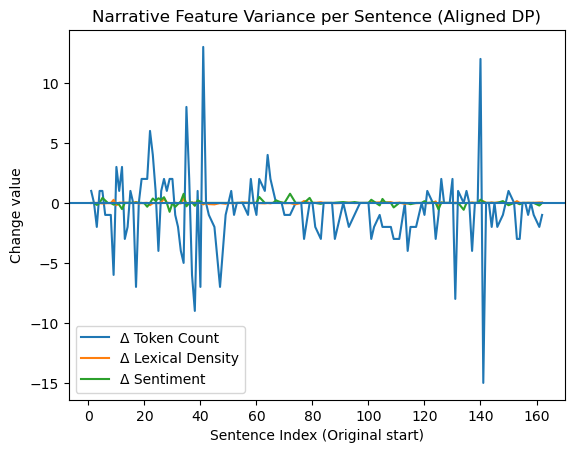

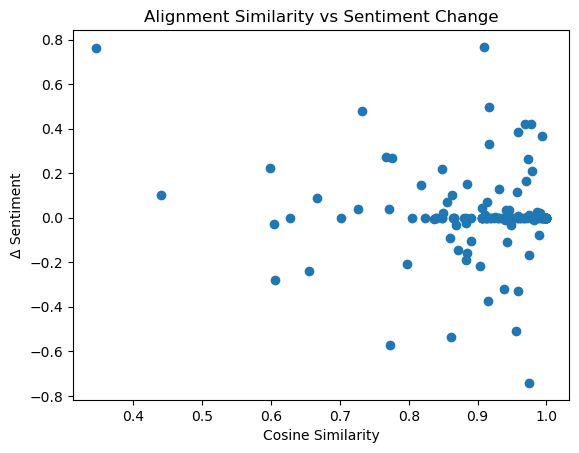

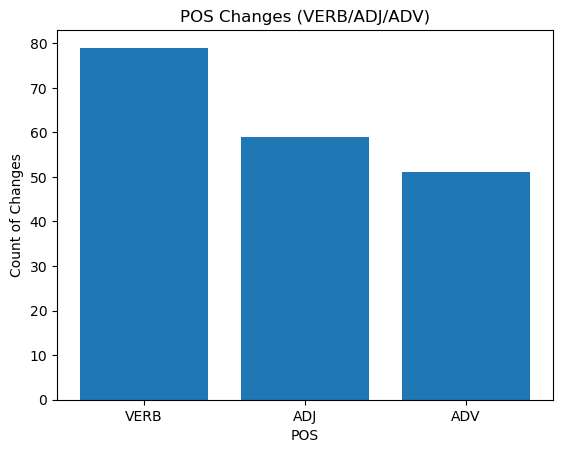

,orig_sent_start,orig_sent_end,back_sent_start,back_sent_end,cosine_sim,delta_verbs,delta_adjs,delta_advs,delta_sentiment,orig_sentence,back_sentence
33,34,34,36,36,0.345,-1,1,1,0.761,What a pity it\nis that Mr. Weston ever though...,I wish she were here again.
39,40,40,42,42,0.440,-2,0,-1,0.103,We must begin; we must go and pay\nwedding vis...,We shall be always meeting!
38,39,39,41,41,0.598,-2,1,0,0.223,"""How often we shall be going to see them, and ...","And you never have strange moods, my dear.”\n\..."
40,41,41,43,43,0.604,4,0,1,-0.028,"""My dear, how am I to get so far?",We must begin; we must go and pay them the wed...
34,35,35,37,37,0.605,1,0,1,-0.282,"""I cannot agree with you, papa; you know I can...",What a pity Mr. Weston ever thought of her!”\n...
45,49,49,48,48,0.628,0,0,-1,0.000,You know we\nhave settled all that already.,You know we have arranged all that.
37,38,38,40,40,0.655,-1,0,-1,-0.241,This is three times as large.--And you have ne...,This is three times as large.
116,141,141,121,122,0.666,-1,-1,-1,0.088,"""And have you never known the pleasure and tri...","I pity you. I thought you more clever, for, be..."
29,30,30,32,32,0.701,0,0,0,0.000,His spirits required support.,His state of mind required support.
88,106,107,91,91,0.726,0,0,1,0.038,"The chances are that she must be a gainer."" ""W...",The odds are that she will be better off.”\n\n...


,orig_sent_start,orig_sent_end,back_sent_start,back_sent_end,cosine_sim,pos_delta,delta_sentiment,orig_sentence,back_sentence
33,34,34,36,36,0.345,3,0.761,What a pity it\nis that Mr. Weston ever though...,I wish she were here again.
38,39,39,41,41,0.598,3,0.223,"""How often we shall be going to see them, and ...","And you never have strange moods, my dear.”\n\..."
115,140,140,120,120,0.775,3,0.269,You made a lucky guess;\nand that is all that ...,You made a lucky guess; and that is all that c...
34,35,35,37,37,0.605,2,-0.282,"""I cannot agree with you, papa; you know I can...",What a pity Mr. Weston ever thought of her!”\n...
37,38,38,40,40,0.655,2,-0.241,This is three times as large.--And you have ne...,This is three times as large.
109,134,134,114,114,0.773,2,-0.572,"""Success supposes endeavour.",“Success implies effort.
26,27,27,29,29,0.732,1,0.477,All looked up to them.,Everyone looked up to them with respect.
25,26,26,28,28,0.767,1,0.272,The Woodhouses\nwere first in consequence there.,The Woodhouses were the most important people ...
86,104,104,89,89,0.798,0,-0.210,"""Emma knows I never flatter her,"" said Mr. Kni...","“Emma knows I never flatter her,” said Mr. Kni..."


In [6]:
if not df_aligned.empty:
    # Line plot of deltas
    plt.figure()
    plt.plot(df_aligned['orig_sent_start'], df_aligned['delta_tokens'], label='Δ Token Count')
    plt.plot(df_aligned['orig_sent_start'], df_aligned['delta_lexical_density'], label='Δ Lexical Density')
    plt.plot(df_aligned['orig_sent_start'], df_aligned['delta_sentiment'], label='Δ Sentiment')
    plt.title('Narrative Feature Variance per Sentence (Aligned DP)')
    plt.xlabel('Sentence Index (Original start)')
    plt.ylabel('Change value')
    plt.axhline(0)
    plt.legend()
    plt.show()

    # Scatter: cosine similarity vs delta sentiment
    plt.figure()
    plt.scatter(df_aligned['cosine_sim'], df_aligned['delta_sentiment'])
    plt.title('Alignment Similarity vs Sentiment Change')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Δ Sentiment')
    plt.show()

    # POS change counts
    if not df_pos_aligned.empty:
        counts = df_pos_aligned['pos'].value_counts()
        plt.figure()
        plt.bar(counts.index.tolist(), counts.values.tolist())
        plt.title('POS Changes (VERB/ADJ/ADV)')
        plt.xlabel('POS')
        plt.ylabel('Count of Changes')
        plt.show()

    # Quick drift tables
    THRESH = 0.75
    drift = df_aligned[df_aligned['cosine_sim'] < THRESH].sort_values('cosine_sim')
    display(drift[['orig_sent_start','orig_sent_end','back_sent_start','back_sent_end','cosine_sim','delta_verbs','delta_adjs','delta_advs','delta_sentiment','orig_sentence','back_sentence']].head(15))

    df_tmp = df_aligned.copy()
    df_tmp['pos_delta'] = (df_tmp['delta_verbs'].abs() + df_tmp['delta_adjs'].abs() + df_tmp['delta_advs'].abs())
    winners = df_tmp.query("cosine_sim < 0.8 and abs(delta_sentiment) > 0.2").sort_values(['pos_delta','cosine_sim'], ascending=[False, True])
    display(winners[['orig_sent_start','orig_sent_end','back_sent_start','back_sent_end','cosine_sim','pos_delta','delta_sentiment','orig_sentence','back_sentence']].head(20))
else:
    print('df_aligned is empty. Check your inputs.')


## 6.1) DP aligner coverage / alignment-type report

Original sentences covered: 162/162 (100.0%)
Back sentences covered (sum of spans): 139

Alignment types:
align_type
1↔1       102
many↔1     27
1↔many      5
Name: count, dtype: int64

=== Examples: 1↔1 ===


,orig_sent_start,orig_sent_end,back_sent_start,back_sent_end,cosine_sim
0,1,1,1,1,0.997
1,2,2,2,2,0.997
2,3,3,3,3,0.974
3,4,4,4,4,0.999
4,5,5,5,5,0.969



=== Examples: 1↔many ===


,orig_sent_start,orig_sent_end,back_sent_start,back_sent_end,cosine_sim
8,9,9,9,10,0.872
19,20,20,21,22,0.869
100,124,124,103,104,0.848
102,126,126,106,107,0.941
116,141,141,121,122,0.666



=== Examples: many↔1 ===


,orig_sent_start,orig_sent_end,back_sent_start,back_sent_end,cosine_sim
42,43,44,45,45,0.953
43,45,46,46,46,0.933
44,47,48,47,47,0.912
51,55,56,54,54,0.924
56,61,62,59,59,0.916


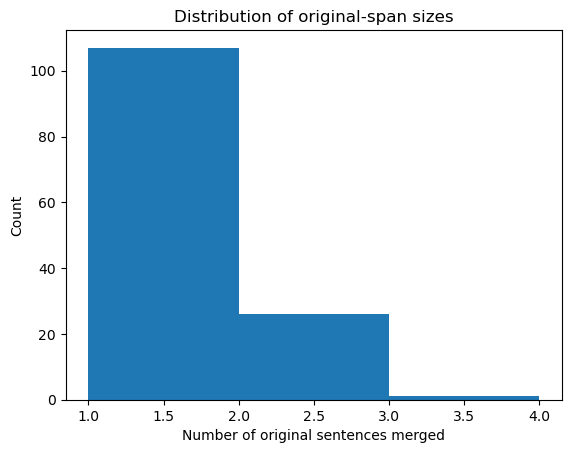

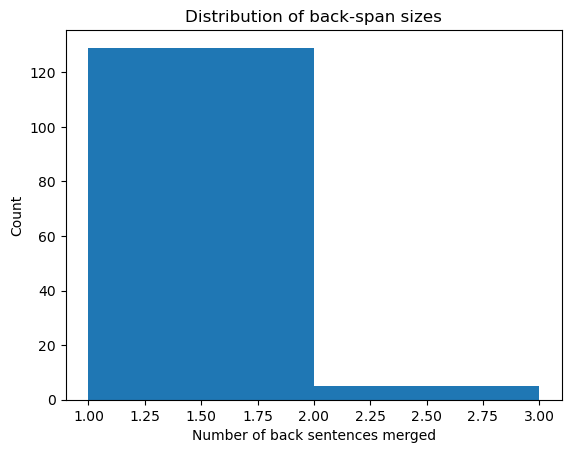

,orig_sent_start,orig_sent_end,back_sent_start,back_sent_end,cosine_sim,orig_sentence,back_sentence
33,34,34,36,36,0.345,What a pity it\nis that Mr. Weston ever though...,I wish she were here again.
39,40,40,42,42,0.440,We must begin; we must go and pay\nwedding vis...,We shall be always meeting!
38,39,39,41,41,0.598,"""How often we shall be going to see them, and ...","And you never have strange moods, my dear.”\n\..."
40,41,41,43,43,0.604,"""My dear, how am I to get so far?",We must begin; we must go and pay them the wed...
34,35,35,37,37,0.605,"""I cannot agree with you, papa; you know I can...",What a pity Mr. Weston ever thought of her!”\n...
45,49,49,48,48,0.628,You know we\nhave settled all that already.,You know we have arranged all that.
37,38,38,40,40,0.655,This is three times as large.--And you have ne...,This is three times as large.
116,141,141,121,122,0.666,"""And have you never known the pleasure and tri...","I pity you. I thought you more clever, for, be..."
29,30,30,32,32,0.701,His spirits required support.,His state of mind required support.
88,106,107,91,91,0.726,"The chances are that she must be a gainer."" ""W...",The odds are that she will be better off.”\n\n...


In [7]:
# --- Coverage / Alignment Type Report ---
total_orig = len(orig_sentences)
covered_orig = int(df_aligned['orig_span_len'].sum())
covered_back = int(df_aligned['back_span_len'].sum())

pct_covered = 100.0 * covered_orig / total_orig if total_orig else 0.0
print(f"Original sentences covered: {covered_orig}/{total_orig} ({pct_covered:.1f}%)")
print(f"Back sentences covered (sum of spans): {covered_back}")

def classify(row):
    a = row['orig_span_len']; b = row['back_span_len']
    if a == 1 and b == 1: return '1↔1'
    if a > 1 and b == 1:  return 'many↔1'
    if a == 1 and b > 1:  return '1↔many'
    return 'many↔many'

df_aligned['align_type'] = df_aligned.apply(classify, axis=1)
print('\nAlignment types:')
print(df_aligned['align_type'].value_counts())

# Examples per class
for k in ['1↔1','1↔many','many↔1','many↔many']:
    subset = df_aligned[df_aligned['align_type'] == k]
    if not subset.empty:
        print(f"\n=== Examples: {k} ===")
        display(subset[['orig_sent_start','orig_sent_end','back_sent_start','back_sent_end','cosine_sim']].head(5))

# Histograms (matplotlib only)
plt.figure()
plt.hist(df_aligned['orig_span_len'], bins=range(1, int(df_aligned['orig_span_len'].max())+2))
plt.title('Distribution of original-span sizes')
plt.xlabel('Number of original sentences merged')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(df_aligned['back_span_len'], bins=range(1, int(df_aligned['back_span_len'].max())+2))
plt.title('Distribution of back-span sizes')
plt.xlabel('Number of back sentences merged')
plt.ylabel('Count')
plt.show()

# Weakest matches for review
bad = df_aligned.sort_values('cosine_sim').head(10)
display(bad[['orig_sent_start','orig_sent_end','back_sent_start','back_sent_end','cosine_sim','orig_sentence','back_sentence']])


In [8]:
# === Alignment examples by class (1↔1, 1↔many, many↔1) ===
# If align_type isn't present (older runs), compute it quickly:
if "align_type" not in df_aligned.columns:
    def _classify(row):
        a = row["orig_span_len"]; b = row["back_span_len"]
        if a == 1 and b == 1: return "1↔1"
        if a > 1 and b == 1:  return "many↔1"
        if a == 1 and b > 1:  return "1↔many"
        return "many↔many"
    df_aligned["align_type"] = df_aligned.apply(_classify, axis=1)

def show_examples(df, k, n=5):
    """Print n examples for alignment class k, prioritizing lowest cosine (most drift)."""
    subset = df[df["align_type"] == k].copy()
    if subset.empty:
        print(f"\n--- {k} EXAMPLES ---\n(none)\n")
        return
    subset = subset.sort_values("cosine_sim").head(n)  # lowest cosine first
    print(f"\n--- {k} EXAMPLES --- (showing {len(subset)} of {df[df['align_type']==k].shape[0]})\n")
    for _, r in subset.iterrows():
        o_span = f"[{int(r.orig_sent_start)}" + (f"-{int(r.orig_sent_end)}]" if r.orig_span_len>1 else "]")
        b_span = f"[{int(r.back_sent_start)}" + (f"-{int(r.back_sent_end)}]" if r.back_span_len>1 else "]")
        print(f"{o_span} ↔ {b_span}  cos={r.cosine_sim:.3f}")
        print("ORIG:", r.orig_sentence.strip())
        print("BACK:", r.back_sentence.strip(), "\n")

for k in ["1↔1", "1↔many", "many↔1"]:
    show_examples(df_aligned, k, n=5)

# Optional: also write a small Markdown file with the same examples
def write_examples_md(df, path="alignment_examples.md", n=5):
    lines = ["# Alignment Examples\n"]
    for k in ["1↔1", "1↔many", "many↔1"]:
        subset = df[df["align_type"] == k].copy().sort_values("cosine_sim").head(n)
        lines.append(f"\n## {k} (showing {subset.shape[0]} of {df[df['align_type']==k].shape[0]})\n")
        if subset.empty:
            lines.append("_None_\n")
            continue
        for _, r in subset.iterrows():
            o_span = f"[{int(r.orig_sent_start)}" + (f"-{int(r.orig_sent_end)}]" if r.orig_span_len>1 else "]")
            b_span = f"[{int(r.back_sent_start)}" + (f"-{int(r.back_sent_end)}]" if r.back_span_len>1 else "]")
            lines.append(f"**{o_span} ↔ {b_span}**  (cos={r.cosine_sim:.3f})\n")
            lines.append(f"- **ORIG:** {r.orig_sentence.strip()}\n")
            lines.append(f"- **BACK:** {r.back_sentence.strip()}\n")
    with open(path, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))
    print(f"\nWrote {path}")





--- 1↔1 EXAMPLES --- (showing 5 of 102)

[34] ↔ [36]  cos=0.345
ORIG: What a pity it
is that Mr. Weston ever thought of her!"
BACK: I wish she were here again. 

[40] ↔ [42]  cos=0.440
ORIG: We must begin; we must go and pay
wedding visit very soon."
BACK: We shall be always meeting! 

[39] ↔ [41]  cos=0.598
ORIG: "How often we shall be going to see them, and they coming to see
us!--We shall be always meeting!
BACK: And you never have strange moods, my dear.”

“How often we shall go and see them, and they will come and see us! 

[41] ↔ [43]  cos=0.604
ORIG: "My dear, how am I to get so far?
BACK: We must begin; we must go and pay them the wedding visit very soon.”

“My dear, how am I to get so far? 

[35] ↔ [37]  cos=0.605
ORIG: "I cannot agree with you, papa; you know I cannot.
BACK: What a pity Mr. Weston ever thought of her!”

“I cannot agree with you, Papa; you know I cannot. 


--- 1↔many EXAMPLES --- (showing 5 of 5)

[141] ↔ [121-122]  cos=0.666
ORIG: "And have you never known 

In [9]:
# Uncomment to create the markdown file:
write_examples_md(df_aligned, "emma_ch1_alignment_examples.md", n=5)


Wrote emma_ch1_alignment_examples.md
